# 2021/12/26
# 本代码绘制论文version1.0的 fig7
# 第一行为位势高度差
# 第二行为越赤道气流降水

In [1]:
import os
import sys
import xarray as xr
import numpy as np
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *


path    =  "/home/sun/data/merra2_multi/"
files   =  os.listdir(path)  ;  files.sort()

level   =  925

f0      =  xr.open_dataset(path+"0707.climate.nc")

# 生成一个数组储存单层气流
u       =  np.zeros((365,f0.U.shape[2],f0.U.shape[3]))
v       =  u.copy()

# 把数据放进去
for i in range(0,len(files)):
    f1      =  xr.open_dataset(path+files[i]).sel(lev=level)
    u[i,:]  =  f1.U.data[0,:]
    v[i,:]  =  f1.V.data[0,:]


# 处理降水数据
f2       =  xr.open_dataset("/home/sun/data/gpcp_prect_365_climate.nc")

#  都处理成pentad average
u_pentad  =  np.zeros((73,f0.U.shape[2],f0.U.shape[3]))
v_pentad  =  u_pentad.copy()
prect_pentad  =  np.zeros((73,f2.prect.shape[1],f2.prect.shape[2]))
for i in range(0,73):
    u_pentad[i,:]  =  np.average(u[i*5:i*5+5,:],axis=0)
    v_pentad[i,:]  =  np.average(v[i*5:i*5+5,:],axis=0)
    prect_pentad[i,:]  =  np.average(f2.prect[i*5:i*5+5,:],axis=0)

# 给u v加上维度属性
wind     =xr.Dataset(
    {
        "u": (["time", "lat", "lon"], u_pentad),
        "v": (["time", "lat", "lon"], v_pentad),
    },
    coords={
        "lon": (["lon"], f0.lon.data),
        "lat": (["lat"], f0.lat.data),
        "time": (["time"], np.linspace(1,73,73)),
    },
)

prect     =xr.Dataset(
    {
        "prect": (["time", "lat", "lon"], prect_pentad),
    },
    coords={
        "lon": (["lon"], f2.lon.data),
        "lat": (["lat"], f2.lat.data),
        "time": (["time"], np.linspace(1,73,73)),
    },
)




# 设计个给出经纬度计算区域平均的函数
def cal_regional_average(var,axis_turple):
    average_data  =  np.zeros((var.shape[0]))

    for i in range(0,var.shape[0]):
        average_data[i]  =  np.nanmean(var.sel(lat=slice(axis_turple[0],axis_turple[1]),lon=slice(axis_turple[2],axis_turple[3])).data[i,:])
    
    return average_data

# 现在开始对印度洋的越赤道气流进行统计分析
# 40-50 50-60 60-70 70-80 80-90 90-100
# 纬度先试试-5 5

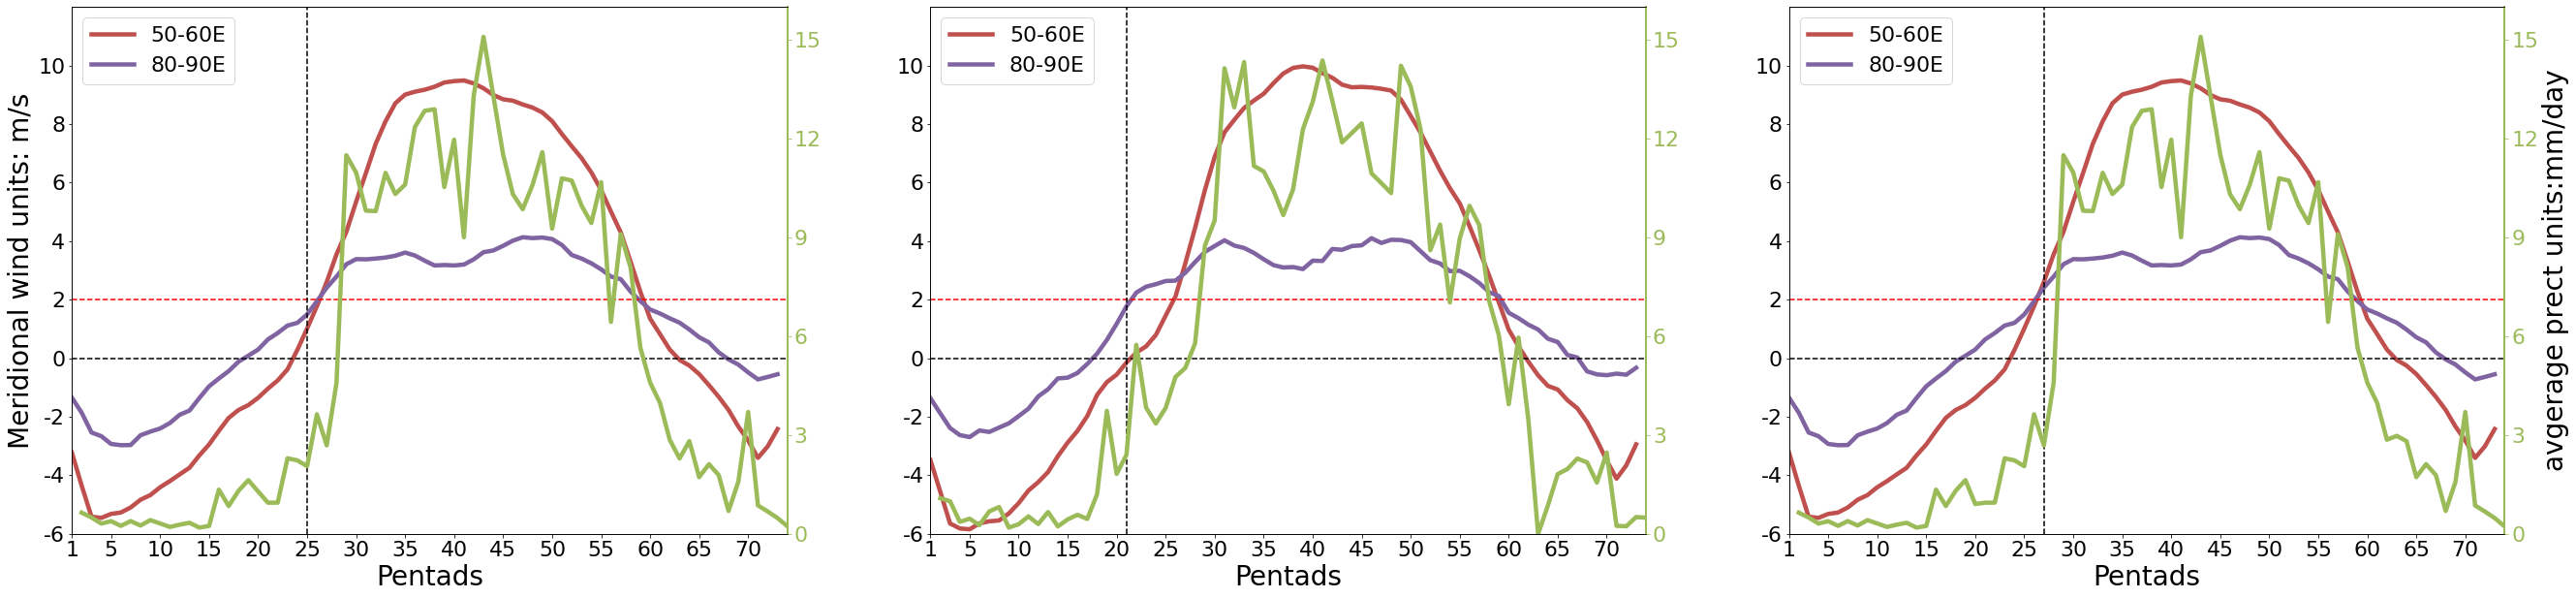

In [3]:
# 坐标轴字体大小
size1  =  28
size2  =  22


cross_equator   =   np.zeros((6,73))
for i in range(40,100,10):
    cross_equator[int((i-40)/10),:]  =  cal_regional_average(wind.v,(-5,5,i,i+10))

# 计算区域平均降水
prect.prect.data[prect.prect.data>100]  =  0
# 这里是对缺测值进行插值
bob_prect  =  cal_regional_average(prect.prect,(10,25,90,100))
bob_prect[42] = 0.5*(bob_prect[41]+bob_prect[43])
bob_prect[18] = 0.5*(bob_prect[17]+bob_prect[19])
bob_prect[61] = 0.5*(bob_prect[60]+bob_prect[63])


#平滑
labels =  ['40-50E', '50-60E', '60-70E', '70-80E', '80-90E', '90-100E']
filted =  np.zeros((6,73))


#---------------------------------平均年-----------------------------------------
fig    =  plt.figure(figsize=(45,10))
ax     =  fig.add_subplot(131)
for i in range(1,5):
    filted[i,:]  =  np.convolve(cross_equator[i,:],np.ones(5)/5,mode='same')
    
    
ax.plot(filted[1],label=labels[1],color='#c0504d',linewidth=4.5)
ax.plot(filted[4],label=labels[4],color='#8064a2',linewidth=4.5)

ax.set_xlim((0, 73))
ax.set_ylim((-6, 12))

#设置x轴坐标
x_ticklabel  =  np.arange(0,73,5)
x_ticklabel[0]  =  1
x_tick = np.arange(0,73,5)-1
x_tick[0] = 0

ax.set_yticks(np.arange(-6,12,2))
ax.set_yticklabels(np.arange(-6,12,2),fontsize=size2)

ax.set_xticks(x_tick)
ax.set_xticklabels(x_ticklabel,fontsize=size2)


ax.plot([0,73],[0,0],'k--')
ax.plot([0,73],[2,2],'r--')


ax.plot([24,24],[-6,14],'k--')

ax.legend(loc='upper left',prop={'size': 22})

ax.set_ylabel("Meridional wind units: m/s",fontsize=size1)
ax.set_xlabel("Pentads",fontsize=size1)

ax2  =  ax.twinx()
filted_bob_prect  =  np.convolve(bob_prect,np.ones(5)/5,mode='same')
ax2.set_ylim((0,16))

ax2.set_yticks(np.arange(0,16,3))
ax2.set_yticklabels(np.arange(0,16,3),fontsize=size2)

ax2.yaxis.label.set_color('#9bbb59')
ax2.tick_params(axis='y', colors='#9bbb59')
ax2.spines['right'].set_color('#9bbb59')
ax2.spines['right'].set_lw(2)

ax2.plot(np.linspace(1,73,73),bob_prect,color='#9bbb59',alpha=1,linewidth=4.5)


# -----------------------------------------早年------------------------------------------------
path    =  "/home/sun/qomo-data/year_mean/multi_early/"
files   =  os.listdir(path)  ;  files.sort()

#level   =  925

f0      =  xr.open_dataset(path+"early_multi_0915.climate.nc")

# 生成一个数组储存单层气流
u       =  np.zeros((365,f0.U.shape[2],f0.U.shape[3]))
v       =  u.copy()

# 把数据放进去
for i in range(0,len(files)):
    f1      =  xr.open_dataset(path+files[i]).sel(lev=level)
    u[i,:]  =  f1.U.data[0,:]
    v[i,:]  =  f1.V.data[0,:]


# 处理降水数据
f2       =  xr.open_dataset("/home/sun/data/gpcp_prect_365_climate.nc")
prect_files  =  os.listdir("/home/sun/qomo-data/year_mean/gpcp_97_19_early/") ; prect_files.sort()

#  都处理成pentad average
u_pentad  =  np.zeros((73,f0.U.shape[2],f0.U.shape[3]))
v_pentad  =  u_pentad.copy()
prect_pentad  =  np.zeros((73,f2.prect.shape[1],f2.prect.shape[2]))
for i in range(0,73):
    u_pentad[i,:]  =  np.average(u[i*5:i*5+5,:],axis=0)
    v_pentad[i,:]  =  np.average(v[i*5:i*5+5,:],axis=0)
    # 处理降水
    for j in range(i*5,i*5+5):  
        prect_pentad[i,:]  +=  xr.open_dataset("/home/sun/qomo-data/year_mean/gpcp_97_19_early/"+prect_files[j]).precip.data[0,:,:]/5

# 给u v加上维度属性
wind     =xr.Dataset(
    {
        "u": (["time", "lat", "lon"], u_pentad),
        "v": (["time", "lat", "lon"], v_pentad),
    },
    coords={
        "lon": (["lon"], f0.lon.data),
        "lat": (["lat"], f0.lat.data),
        "time": (["time"], np.linspace(1,73,73)),
    },
)

prect     =xr.Dataset(
    {
        "prect": (["time", "lat", "lon"], prect_pentad),
    },
    coords={
        "lon": (["lon"], f2.lon.data),
        "lat": (["lat"], f2.lat.data),
        "time": (["time"], np.linspace(1,73,73)),
    },
)


cross_equator   =   np.zeros((6,73))
for i in range(40,100,10):
    cross_equator[int((i-40)/10),:]  =  cal_regional_average(wind.v,(-5,5,i,i+10))

# 计算区域平均降水
prect.prect.data[prect.prect.data>100]  =  0
# 这里是对缺测值进行插值
bob_prect  =  cal_regional_average(prect.prect,(10,25,90,100))
bob_prect[42] = 0.5*(bob_prect[41]+bob_prect[43])


#平滑
labels =  ['40-50E', '50-60E', '60-70E', '70-80E', '80-90E', '90-100E']
filted =  np.zeros((6,73))
ax     =  fig.add_subplot(132)
for i in range(1,5):
    filted[i,:]  =  np.convolve(cross_equator[i,:],np.ones(5)/5,mode='same')
    
    
ax.plot(filted[1],label=labels[1],color='#c0504d',linewidth=4.5)
ax.plot(filted[4],label=labels[4],color='#8064a2',linewidth=4.5)

ax.set_xlim((0, 73))
ax.set_ylim((-6, 12))

#设置x轴坐标

x_ticklabel  =  np.arange(0,73,5)
x_ticklabel[0]  =  1

ax.set_yticks(np.arange(-6,12,2))
ax.set_yticklabels(np.arange(-6,12,2),fontsize=size2)

ax.set_xticks(x_tick)
ax.set_xticklabels(x_ticklabel,fontsize=size2)

ax.plot([0,73],[0,0],'k--')
ax.plot([0,73],[2,2],'r--')


ax.plot([20,20],[-6,14],'k--')

ax.legend(loc='upper left',prop={'size': 22})

ax.set_xlabel("Pentads",fontsize=size1)

ax2  =  ax.twinx()
filted_bob_prect  =  np.convolve(bob_prect,np.ones(5)/5,mode='same')
ax2.set_ylim((0,16))

ax2.set_yticks(np.arange(0,16,3))
ax2.set_yticklabels(np.arange(0,16,3),fontsize=size2,)

ax2.yaxis.label.set_color('#9bbb59')
ax2.tick_params(axis='y', colors='#9bbb59')
ax2.spines['right'].set_color('#9bbb59')
ax2.spines['right'].set_lw(2)

ax2.plot(np.linspace(1,73,73),bob_prect,color='#9bbb59',alpha=1,linewidth=4.5)

# ---------------------------------------------------晚年------------------------------------------------------------
path    =  "/home/sun/qomo-data/year_mean/multi_late/"
files   =  os.listdir(path)  ;  files.sort()

level   =  925

f0      =  xr.open_dataset(path+"late_multi_0915.climate.nc")

# 生成一个数组储存单层气流
u       =  np.zeros((365,f0.U.shape[2],f0.U.shape[3]))
v       =  u.copy()

# 把数据放进去
for i in range(0,len(files)):
    f1      =  xr.open_dataset(path+files[i]).sel(lev=level)
    u[i,:]  =  f1.U.data[0,:]
    v[i,:]  =  f1.V.data[0,:]


# 处理降水数据
f2       =  xr.open_dataset("/home/sun/data/gpcp_prect_365_climate.nc")
prect_files  =  os.listdir("/home/sun/qomo-data/year_mean/gpcp_97_19_late/") ; prect_files.sort()

#  都处理成pentad average
u_pentad  =  np.zeros((73,f0.U.shape[2],f0.U.shape[3]))
v_pentad  =  u_pentad.copy()
prect_pentad  =  np.zeros((73,f2.prect.shape[1],f2.prect.shape[2]))
for i in range(0,73):
    u_pentad[i,:]  =  np.average(u[i*5:i*5+5,:],axis=0)
    v_pentad[i,:]  =  np.average(v[i*5:i*5+5,:],axis=0)
    # 处理降水
    for j in range(i*5,i*5+5):  
        prect_pentad[i,:]  +=  xr.open_dataset("/home/sun/qomo-data/year_mean/gpcp_97_19_late/"+prect_files[j]).precip.data[0,:,:]/5

# 给u v加上维度属性
wind     =xr.Dataset(
    {
        "u": (["time", "lat", "lon"], u_pentad),
        "v": (["time", "lat", "lon"], v_pentad),
    },
    coords={
        "lon": (["lon"], f0.lon.data),
        "lat": (["lat"], f0.lat.data),
        "time": (["time"], np.linspace(1,73,73)),
    },
)

prect     =xr.Dataset(
    {
        "prect": (["time", "lat", "lon"], prect_pentad),
    },
    coords={
        "lon": (["lon"], f2.lon.data),
        "lat": (["lat"], f2.lat.data),
        "time": (["time"], np.linspace(1,73,73)),
    },
)


cross_equator   =   np.zeros((6,73))
for i in range(40,100,10):
    cross_equator[int((i-40)/10),:]  =  cal_regional_average(wind.v,(-5,5,i,i+10))

# 计算区域平均降水
prect.prect.data[prect.prect.data>100]  =  0
# 这里是对缺测值进行插值
bob_prect  =  cal_regional_average(prect.prect,(10,25,90,100))
bob_prect[42] = 0.5*(bob_prect[41]+bob_prect[43])



#平滑
labels =  ['40-50E', '50-60E', '60-70E', '70-80E', '80-90E', '90-100E']
filted =  np.zeros((6,73))
ax     =  fig.add_subplot(133)
for i in range(1,5):
    filted[i,:]  =  np.convolve(cross_equator[i,:],np.ones(5)/5,mode='same')
    
    
ax.plot(filted[1],label=labels[1],color='#c0504d',linewidth=4.5)
ax.plot(filted[4],label=labels[4],color='#8064a2',linewidth=4.5)

ax.set_xlim((0, 73))
ax.set_ylim((-6, 12))

#设置x轴坐标
x_tick = np.arange(0,73,5)-1
x_tick[0] = 0
x_ticklabel  =  np.arange(0,73,5)
x_ticklabel[0]  =  1

ax.set_yticks(np.arange(-6,12,2))
ax.set_yticklabels(np.arange(-6,12,2),fontsize=size2)

ax.set_xticks(x_tick)
ax.set_xticklabels(x_ticklabel,fontsize=size2)
ax.plot([0,73],[0,0],'k--')
ax.plot([0,365],[2,2],'r--')


ax.plot([26,26],[-6,14],'k--')

ax.legend(loc='upper left', prop={'size': 22})



ax.set_xlabel("Pentads",fontsize=size1)

ax2  =  ax.twinx()
filted_bob_prect  =  np.convolve(bob_prect,np.ones(5)/5,mode='same')
ax2.set_ylim((0,16))

ax2.set_yticks(np.arange(0,16,3))
ax2.set_yticklabels(np.arange(0,16,3),fontsize=size2)
ax2.set_ylabel("avgerage prect units:mm/day",fontsize=size1)

#ax2.yaxis.label.set_color('#9bbb59')
ax2.tick_params(axis='y', colors='#9bbb59')
ax2.spines['right'].set_color('#9bbb59')
ax2.spines['right'].set_lw(2)

ax2.plot(np.linspace(1,73,73),bob_prect,color='#9bbb59',alpha=1,linewidth=4.5)

plt.savefig("/home/sun/paint/lunwen/version2.0/lunwen_version2.0_fig8_cross_prect_220411.pdf",dpi=300)
plt.show()